<a href="https://colab.research.google.com/github/dayekb/urfu_master_class/blob/main/%D0%A3%D1%80%D0%A4%D0%A3_Stable_Diffusion_%D0%A0%D0%B0%D0%B7%D0%BD%D0%BE%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом Блокноте мы пользуемся GPU "любезно" предоставленной Google

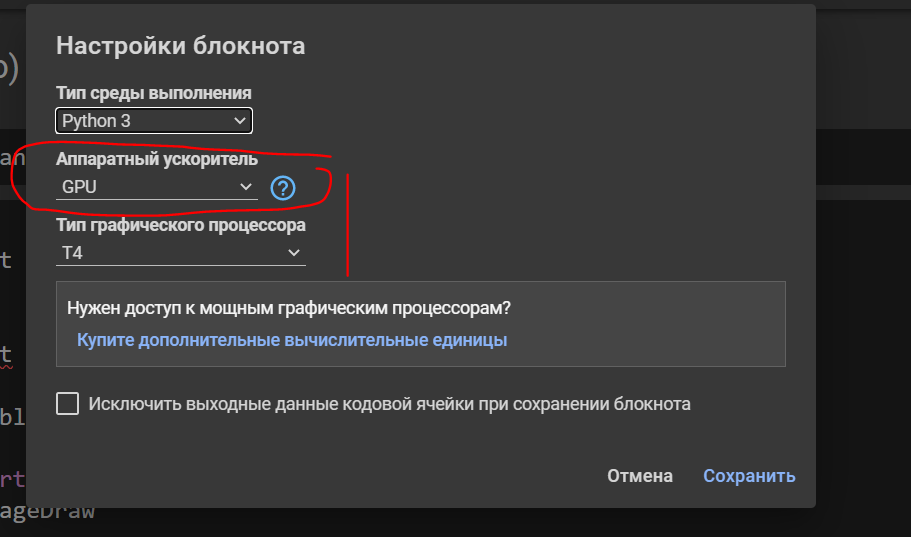

# Импорт и установка хорошего)

In [ ]:
!pip install diffusers transformers scipy ftfy "ipywidgets>=7,<8"

In [ ]:
import os
import google.colab.output

import torch
from torch import autocast

from diffusers import StableDiffusionPipeline

from huggingface_hub import notebook_login
from PIL import Image, ImageDraw

device = 'cuda'

# Pipeline по Умолчанию

Нам нужно знать название модели (полное)

  [Модель](https://huggingface.co/stabilityai/stable-diffusion-2-base)

 Пользуемся готовым решением - загружаем уже обученную модель по имени (всё остальное ребята из Hugging Face сделали за нас)

 Функция с которой мы будем работать - `pipe` (пайплайн)

  Нажимаем и ждем пару минут)

In [ ]:
model_id = "stabilityai/stable-diffusion-2-base"

pipe = StableDiffusionPipeline.from_pretrained(model_id, 
                                               torch_dtype=torch.float16,
                                               low_cpu_mem_usage=False)

pipe = pipe.to(device)

## Запуск

*Интерфейс* взаимодействия простой

Есть `prompt` - текст "чего мы хотим"

Он подается на вход нашего `pipe`

И берем только изображение

In [ ]:
prompt = 'Pikachu in field, hd, realistic '
with autocast(device):
    image = pipe(prompt)['images'][0]
image

Как-бы проблема

Если запустить еще раз - будет новое

In [ ]:
prompt = 'Pikachu in field, hd, realistic '
with autocast(device):
    image = pipe(prompt)['images'][0]
image

## Повторяемая генерация

Чтобы повторно использовать изображение (например чуточку передалать), нам нужно самим генерировать Скрытое пространство. В противном случае конвейер сделает это внутри, и у нас не будет возможности их воспроизвести.

Скрытое Пространство — это начальный случайный гауссовский шум, который преобразуется в реальные изображения в процессе диффузии.

Чтобы сгенерировать их, мы будем использовать другое случайное начальное число для каждого Скрытое Пространство и мы сохраним их, чтобы мы могли повторно использовать их позже.

In [ ]:
generator = torch.Generator(device=device)
seed = generator.seed()
generator = generator.manual_seed(seed)

width = 512
height = 512

latents = torch.randn(
    (1, pipe.unet.config.in_channels, height // 8, width // 8),
    generator = generator,
    device = device
)

In [ ]:
seed

Теперь подаем на вход не только текстовое описание ( `prompt` ), но и шум из которого мы рисуем картинку (`latents`)

In [ ]:
prompt = 'Pikachu in field, hd, realistic '
with autocast(device):
    image = pipe(prompt,
                 latents = latents,)['images'][0]
image

Проверяем на повторяемость

In [ ]:
prompt = 'Pikachu in field, hd, realistic '
with autocast(device):
    image = pipe(prompt,
                 latents = latents,)['images'][0]
image

## Про то как сделать что-то из ничего

Зафиксировав сид мы можем "проследить" историю создания

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
num_inference_steps=[1, 2, 3, 4, 5,
                     6, 7, 8, 9, 10,
                     15,20,25,30,40,50,]
images = []
with autocast(device):
    for num_i in num_inference_steps:

        image = pipe(
            prompt,
            latents = latents,
            num_inference_steps=num_i
                )["images"]
        images.append(image[0])

Немного страшно, но что поделать

In [ ]:
image_grid(images, 4, 4)

## Жаловаться бывает хорошо

Можно сказать модели не только "как рисовать", но и "как точно не надо рисовать"  `negative_prompt`

In [ ]:
prompt = 'Pikachu in field, hd, realistic'
negative_prompt = 'ugly, monochrome, lowres, bad anatomy, worst quality, low quality, crop, watermark, (out of frame)'

with autocast(device):
    image = pipe(prompt,
                 latents = latents,
                 negative_prompt = negative_prompt)['images'][0]
image

## С чем еще можно играться

Можно еще варьировать параметр `guidance_scale`

Своеобразный "вес" текстового описания

Чем меньше тем более "случайным" будет картинка

In [ ]:
guidance_scale=[1, 2, 3, 4, 5, 
                6, 7, 8, 9, 10, 
                10.5, 11, 11.5, 12, 12.5,]
images = []
with autocast(device):
    for gs_i in guidance_scale:

        image = pipe(
            prompt,
            latents = latents,
            guidance_scale=gs_i
                )["images"]
        images.append(image[0])

In [ ]:
image_grid(images, 5, 3)

## Массовое рисование

Можно сразу "пачкой" рисовать, а потом отбирать "что получше"

In [ ]:
num_images = 4

generator = torch.Generator(device=device)

latents = None
seeds = []
for _ in range(num_images):
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    
    image_latents = torch.randn(
        (1, pipe.unet.config.in_channels, height // 8, width // 8),
        generator = generator,
        device = device
    )
    latents = image_latents if latents is None else torch.cat((latents, image_latents))

In [ ]:
prompt = 'Pikachu in field, hd, realistic'
negative_prompt = 'ugly, monochrome, lowres, bad anatomy, worst quality, low quality, crop, watermark, (out of frame)'

with autocast(device):
    images = pipe(
        [prompt] * num_images,
        latents = latents,
        negative_prompt = [negative_prompt]* num_images
    )["images"]

In [ ]:
image_grid(images, 2, 2)

In [ ]:
seed = seeds[3]   # Например выбирем 4-ый
seed

In [ ]:
generator.manual_seed(seed)

latents = torch.randn(
    (1, pipe.unet.config.in_channels, height // 8, width // 8),
    generator = generator,
    device = device
)

In [ ]:
with autocast(device):
    image = pipe(
        prompt,
        latents = latents,
        negative_prompt  = negative_prompt
    )["images"]
    
image[0]

# Дополнительно можно ознакомиться 

**Генерация изображений Img2Img**<br />
https://colab.research.google.com/drive/1enyAeGJ5IP8nZSn9hdpMi52TPH9IsEDz?usp=sharing<br />
Рисуем на базе наброска, или заменяем что-то по маске (Inpaint)<br />
Так же небольшая демонстрация Gradio для "интерфейса из ничего"<br /> 


**Рисуем изображения по контурам другого**<br />
https://colab.research.google.com/drive/1B_xAsdqzwkfZMNrs_r3jbbwiNaxv4BPO?usp=sharing<br />
Знакомство с ControlNet<br />
Рисуем по границам (контурам)


**Генерируем изображения используя позы другого**<br />
https://colab.research.google.com/drive/1_sh1_Vi9CHfhEIK2kOx0Z0OfN5hHxJAa?usp=sharing<br />
Опять ControlNet<br />
Позы (и для этого есть нейронка)

Разные специализированные рисовалки 

В основном, конечно, аниме

https://huggingface.co/nitrosocke/Ghibli-Diffusion

https://huggingface.co/nitrosocke/Arcane-Diffusion

https://huggingface.co/hakurei/waifu-diffusion

https://huggingface.co/dreamlike-art/dreamlike-photoreal-2.0 (наконец не аниме - типа фотореализм)